In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
from arcgis.gis import GIS
import pykrige.uk
from tqdm.notebook import tqdm
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib
from scipy.spatial import cKDTree
from pygeostat.data import iotools
import scipy
import cmcrameri.cm as cmc

In [3]:
CA_map = gpd.read_file('Shapefiles/CA_State_TIGER2016.shp')
CA_map.to_crs(epsg='4326', inplace=True)

CV_map = gpd.read_file('Shapefiles/Alluvial_Bnd.shp')
CV_map.to_crs(epsg='4326', inplace=True)

In [4]:
def ckdnearest(gdA, gdB):
    '''scipy's binary tree search for finding nearest neighbor points between two geodataframes'''
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [5]:
from scipy.spatial import cKDTree

class tree(object):
    """
    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.
    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting
    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.
    Returns:
    --------
        tree instance: object
    Example:
    --------
    # 'train'
    idw_tree = tree(X1, z1)
    # 'test'
    spacing = np.linspace(-5., 5., 100)
    X2 = np.meshgrid(spacing, spacing)
    X2 = np.reshape(X2, (2, -1)).T
    z2 = idw_tree(X2)
    See also:
    ---------
    demo()
    """
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize )
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):
        """
        Instantiate KDtree for fast query of k-nearest neighbour distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N sample points in a d-dimensional space.
            z: (N,) ndarray
                Corresponding scores.
            leafsize: int (default 10)
                Leafsize of KD-tree data structure;
                should be less than 20.
        Returns:
        --------
            idw_tree instance: object
        Notes:
        -------
        Wrapper around __init__().
        """
        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        """
        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / np.sum(1./self.distances, axis=1)
        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        Notes:
        ------
        Wrapper around __call__().
        """
        return self.__call__(X, k, eps, p, regularize_by)

In [6]:
# user input
in_path = './shallow_measurements_all_cvhm.csv'
target_year = '2021'
target_season = 'spring'
monitoring_weight = 0.8
n_realizations = 10000
crs_latlon='epsg:4326' # WGS 84
crs_projected='epsg:3488' # California Albers

In [7]:
x_ = np.arange(-123, -118, 0.10)
y_ = np.arange(34.5, 41, 0.10)
print(len(x_))
print(len(y_))
xx,yy = np.meshgrid(x_,y_,indexing = 'ij')
xx_flat = xx.reshape(-1)
yy_flat = yy.reshape(-1)

meshgrid_points = [Point(xy) for xy in zip(xx_flat, 
                                           yy_flat)]
meshgrid_frame = gpd.GeoDataFrame(meshgrid_points, crs=crs_latlon, geometry=meshgrid_points)

50
65


In [8]:
new_binary = mpl.colors.ListedColormap(np.array([[1., 1., 1., 1.],
       [0., 0., 0., 0.]]))
CV_overlay = np.zeros(xx.shape)
CV_geom = CV_map['geometry'].values[0]
for i in tqdm(range(len(CV_overlay))):
    for j in range(len(CV_overlay[0,:])):
        potentialPoint = Point(xx[i,j], yy[i,j])
        if potentialPoint.within(CV_geom):
            CV_overlay[i,j] = 1

  0%|          | 0/50 [00:00<?, ?it/s]

## Load Data

In [11]:
well_measurements = pd.read_csv(in_path, parse_dates=['MSMT_DATE'])
print(len(well_measurements))
site_points = [Point(xy) for xy in zip(well_measurements["LONGITUDE"], well_measurements["LATITUDE"])]


well_measurements = gpd.GeoDataFrame(well_measurements, crs=crs_latlon, geometry=site_points)
well_measurements = well_measurements.to_crs(crs_projected)

0


## Filter Data by Date

In [12]:
if target_season == 'spring':
    start_month = '01'
    mid_month = '03'
    end_month = '06'
else:
    start_month = '06'
    mid_month = '09'
    end_month='12'

mask = ((well_measurements['MSMT_DATE'] > target_year+start_month+'01') & 
        (well_measurements['MSMT_DATE'] <= target_year+end_month+'01'))

In [13]:
timeframed_measurements = well_measurements.loc[mask]
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'].notnull()]

Taking only those points whose water surface elevation is lower than ground surface elevation.

In [14]:
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'] > 0]

## Site filtering

In [15]:
timeframed_measurements['DROP'] = True

In [16]:
site_codes = list(timeframed_measurements['SITE_CODE'].unique())
print(len(site_codes))
for site_code in site_codes:
    site_code_timeframed_measurements_index = timeframed_measurements.index[
        timeframed_measurements['SITE_CODE']==site_code].tolist()
    if len(site_code_timeframed_measurements_index) == 1:
        timeframed_measurements.loc[site_code_timeframed_measurements_index,'DROP'] = False
    else:
        potential_site_code_timeframed_measurements = timeframed_measurements.loc[
            site_code_timeframed_measurements_index]
        potential_site_code_timeframed_measurements["CLOSEST"] = abs(
            potential_site_code_timeframed_measurements["MSMT_DATE"] - datetime.datetime(
                int(target_year), int(mid_month), 15))
        index_min = potential_site_code_timeframed_measurements["CLOSEST"].idxmin()
        timeframed_measurements.loc[index_min, "DROP"] = False


0


In [17]:
timeframed_measurements.drop(timeframed_measurements.index[timeframed_measurements['DROP']==True], inplace=True)

## Extract X Y and Depth measurements

In [18]:
timeframed_measurements_x = timeframed_measurements['geometry'].x
timeframed_measurements_y = timeframed_measurements['geometry'].y
timeframed_measurements_lat = timeframed_measurements["LATITUDE"]
timeframed_measurements_lon = timeframed_measurements["LONGITUDE"]
timeframed_measurements_z = timeframed_measurements['GSE_GWE']
timeframed_measurements_type = timeframed_measurements["WELL_USE"]

In [19]:
meshgrid_frame = meshgrid_frame.to_crs(crs_projected)

In [20]:
xx_flat = meshgrid_frame['geometry'].x
yy_flat = meshgrid_frame['geometry'].y
xx_yy = np.array((xx_flat,yy_flat)).T

In [21]:
#well_measurements_LVM.to_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv')

In [22]:
#shallow_measurements_csv = iotools.read_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv', headeronly=False, tmin=None)

In [23]:
#iotools.write_gslib(shallow_measurements_csv, 'shallow_measurements_all_cvhm_no_trend_gslib', variables=['LONGITUDE', 'LATITUDE', 'GSE_GWE_NO_TREND'])

Stacking the x, y, and z data together in a new array

In [24]:
timeframed_measurements_xyz = np.vstack((timeframed_measurements_x, timeframed_measurements_y, timeframed_measurements_z)).T

## Bootstrap and Kriging

In [25]:
bootstrap_timeframed_measurements_xyz = np.zeros((n_realizations, int(len(timeframed_measurements_xyz)*0.8), 3))
p_array = np.ones((int(len(timeframed_measurements_xyz))))*(1-monitoring_weight)/len(
    timeframed_measurements_type[timeframed_measurements_type!='Observation'])
p_array[timeframed_measurements_type=='Observation']=monitoring_weight/len(
timeframed_measurements_type[timeframed_measurements_type=='Observation'])
for i in range(len(bootstrap_timeframed_measurements_xyz)):
    bootstrap_indices = np.random.choice(np.arange(len(timeframed_measurements_xyz)), 
                                         size=int(len(timeframed_measurements_xyz)*0.8),
                                        replace=False,
                                        p=p_array)
    bootstrap_timeframed_measurements_xyz[i] = timeframed_measurements_xyz[bootstrap_indices]

ZeroDivisionError: float division by zero

Use grid from above

Set up bootstrap 

In [317]:
bootstrap_IDW = []
for i in tqdm(range(len(bootstrap_timeframed_measurements_xyz))):
    bootstrap_IDW.append(tree(bootstrap_timeframed_measurements_xyz[i,:,:2],
                            bootstrap_timeframed_measurements_xyz[i,:,2]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [318]:
bootstrap_realizations = []
for i in tqdm(range(len(bootstrap_IDW))):
    z = bootstrap_IDW[i](xx_yy)
    bootstrap_realizations.append(z)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [319]:
z_mean = np.array(bootstrap_realizations)
z_mean = np.reshape(z_mean, (n_realizations,len(x_),len(y_)))
z_mean = np.mean(z_mean, axis=0)

In [320]:
z_var = np.array(bootstrap_realizations)
z_var = np.sqrt(np.var(z_var, axis=0))
z_var = np.reshape(z_var, (len(x_),len(y_)))

## Plot Results

Text(306.5740441012261, 0.5, 'Latitude')

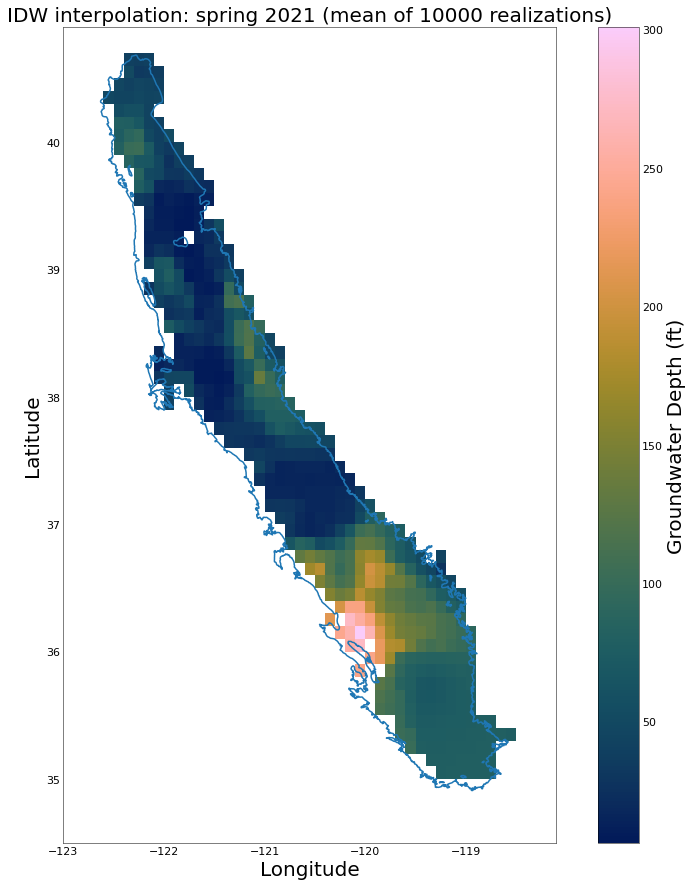

In [321]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
#plt.grid(zorder=2.5, color='k')
CV_map.boundary.plot(ax=ax, zorder=3)
plt.pcolormesh(xx, yy, z_mean, zorder=-2, cmap=cmc.batlow)
#plt.colorbar()
plt.colorbar().set_label(label='Groundwater Depth (ft)',size=20)
#plt.scatter(timeframed_measurements_lon, timeframed_measurements_lat, color='red', s=10)
plt.pcolormesh(xx, yy, CV_overlay, cmap=new_binary, zorder=-1)
plt.title('IDW interpolation: spring 2021 (mean of 10000 realizations)', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)

#plt.savefig('OK_CV_only_bootstrap.png', dpi=300)

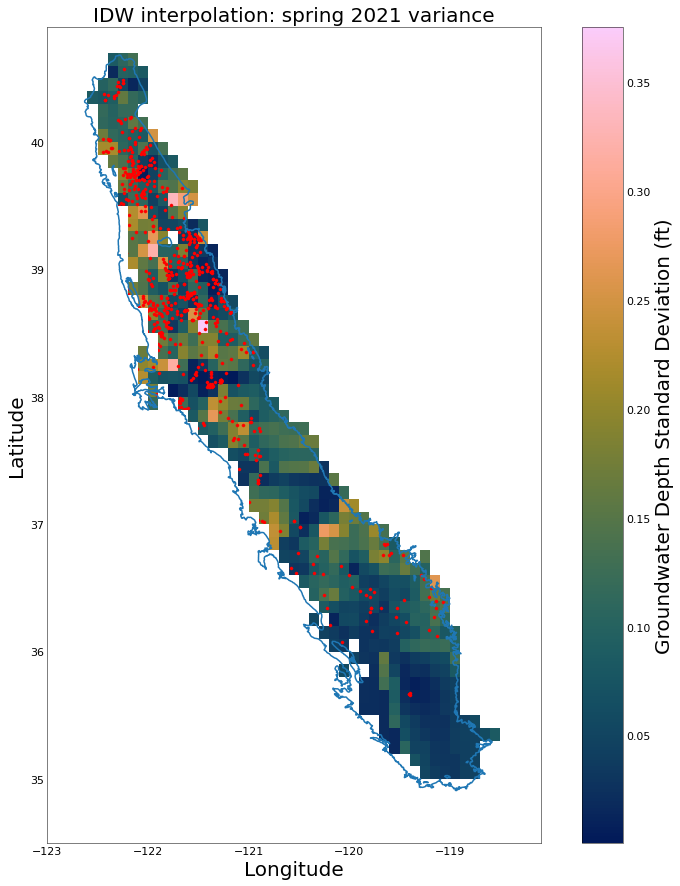

In [322]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(xx, yy, z_var/z_mean, zorder=1, cmap=cmc.batlow)
plt.colorbar().set_label(label='Groundwater Depth Standard Deviation (ft)',size=20)
plt.pcolormesh(xx, yy, CV_overlay, cmap=new_binary, zorder=2)
#plt.scatter(timeframed_measurements_lon, timeframed_measurements_lat, color='red', s=10)
plt.scatter(timeframed_measurements_lon, timeframed_measurements_lat, color='red', s=10)
plt.title('IDW interpolation: spring 2021 variance', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.grid(zorder=0)
#plt.savefig('OK_CV_only_vari.png', dpi=300)

piezometer at every well?

consider agricultural and residential wells in areas with not many observation wells

check quality control codes

worried about semiconfined (could be higher than the water table if pressurized) Need some method of confirming if a well is in an unconfined vs semiconfined zone (clay percent? well logs? insar?)

Christina thinks the answer could be in the well logs (line for depth of first water -> water level at level of confirmation)

DWR has some of those logs maybe? still a rangling effort